# Definition of the model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from constants import *
from GTZAN import GTZAN
from visualization import *
import time
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


In [2]:
class BeatTracker(nn.Module):
    
    def __init__(self, hidden_size=128, num_layers=2):
        super(BeatTracker, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
                        nb, 
                        hidden_size, 
                        num_layers, 
                        bidirectional=True, 
                        dropout=0.5,
                        batch_first=True)
        self.hid_to_beat = nn.Linear(2 * hidden_size, 2)
        self.hidden = None
        
        self.loss_function = nn.NLLLoss()
        
        self.lr = 0.001
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, spec):
        x = self.lstm(spec)[0]
        x = self.hid_to_beat(x)
        x = F.log_softmax(x, dim=-1)
        return x
    
    def set_lr(self, lr):
        self.lr = lr
        for p in self.optimizer.param_groups:
            p['lr'] = lr
    
    def loss(self, spec, onsets, isbeat):
        output = self(spec)
        output = output[onsets == 1]
        target = isbeat[onsets == 1]
        loss = self.loss_function(output, target)
        return loss

    def loss_from_dataset(self, dataset, batch_size=32):
        dataloader = DataLoader(dataset, batch_size=batch_size)
        loss = 0
        with torch.no_grad():
            loss = 0
            for specs, onsets, isbeat in dataloader:
                loss += self.loss(specs, onsets, isbeat).item()
            loss /= len(dataloader)
        return loss
    
    def learn(self, spec, onsets, isbeat):
        self.optimizer.zero_grad()
        output = self(spec)
        output = output[onsets == 1]
        target = isbeat[onsets == 1]
        loss = self.loss_function(output, target)
        loss.backward()
        self.optimizer.step()
        
        predic = torch.argmax(output, dim=1)
        accuracy = torch.sum(predic == target).item() / predic.shape.numel()
        
        return loss.item(), accuracy
    
    def fit(self, dataset, validset, batch_size=1, epochs=1):
        len_dataloader = -(-len(dataset) // batch_size)  # quick ceiling function
        loss_hist = np.zeros((epochs, len_dataloader))
        accu_hist = np.zeros((epochs, len_dataloader))
        valid_hist= np.zeros(epochs)
        for e in range(epochs):
            start = time.time()
            
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, (spec, onsets, isbeat) in enumerate(dataloader):
                loss, accuracy = self.learn(spec, onsets, isbeat)
                loss_hist[e, i] = loss
                accu_hist[e, i] = accuracy
            
            valid_hist[e] = self.loss_from_dataset(validset)
            
            end = time.time()
            t = end - start
            eta = str(datetime.timedelta(seconds=int(t * (epochs - e - 1))))
            print(f'| Epoch: {e + 1:{len(str(epochs))}} | ', end='')
            print(f'Loss: {np.mean(loss_hist[e]):7.4f} | ', end='')
            print(f'Valid loss: {valid_hist[e]:7.4f} | ', end='')
            print(f'Accuracy: {np.mean(accu_hist[e]):5.4f} | ', end='')
            print(f'{t / len(dataloader):.2f} s/b | Eta: {eta} |')
        return loss_hist, accu_hist, valid_hist
    
    def predict(self, specs, onsets):
        """So far only works if batch_size = 1"""
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            pred_t = torch.argmax(output, dim=1)
            onsets_frames = np.argwhere(onsets.squeeze(0) == 1).squeeze(0)
            beats_frames = onsets_frames[pred_t == 1]
            pred = torch.zeros_like(onsets)
            pred[:, beats_frames] = 1
        return pred
    
    def evaluate(self, specs, onsets, isbeat):
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            target = isbeat[onsets == 1]
            predic = torch.argmax(output, dim=1)
            
            tn = torch.sum((predic == 0) & (target == 0)).item()
            fp = torch.sum((predic == 1) & (target == 0)).item()
            fn = torch.sum((predic == 0) & (target == 1)).item()
            tp = torch.sum((predic == 1) & (target == 1)).item()
        return tn, fp, fn, tp
    
    def evaluate_from_dataset(self, dataset, batch_size=16):
        dataloader = DataLoader(dataset, batch_size=batch_size)
        ttn = 0
        tfp = 0
        tfn = 0
        ttp = 0
        for specs, onsets, isbeat in dataloader:
            tn, fp, fn, tp = self.evaluate(specs, onsets, isbeat)
            ttn += tn
            tfp += fp
            tfn += fn
            ttp += tp
        return ttn, tfp, tfn, ttp
    
    def freeze(self):
        for p in self.parameters():
            p.requires_grad = False
            
    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad = True

class ToTensor(object):
    
    def __call__(self, sample):
        spec_np, onsets_np, isbeat_np = sample
        
        # Normalize to [-1, 1]
        spec_np = 2 * (spec_np - spec_np.min()) / (spec_np.max() - spec_np.min()) - 1
        spec = torch.tensor(spec_np.T, dtype=torch.float, device=device)
        
        onsets = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        isbeat = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        
        onsets[onsets_np] = 1
        isbeat[onsets_np[isbeat_np == 1]] = 1
        
        return spec, onsets, isbeat

totensor = ToTensor()
    
def beat_track(isbeat):
    onset_envelope = isbeat.squeeze(0).numpy()
    tempo, bt = librosa.beat.beat_track(
                            sr=sr, 
                            onset_envelope=onset_envelope, 
                            hop_length=hl, 
                            tightness=800)
    return bt

# GTZAN dataset

Take a subset of the GTZAN dataset preprocessed using `preprocess-GTZAN` and split it into a train set and a validation set.

In [ ]:
dataset = GTZAN(937, 'country', 20, getbeats=True)

Visualize an example.

In [ ]:
spec, onsets, isbeat, beats = dataset[np.random.randint(len(dataset))]

In [ ]:
showspec(spec)

In [ ]:
showdata(spec, onsets, isbeat, beats, duration=10)

# BALLROOM dataset

In [3]:
import BALLROOM

In [4]:
dataset = BALLROOM.BALLROOM(20)

In [7]:
i = np.random.randint(len(dataset))
print(i)

19


In [8]:
spec, onsets, isbeat = dataset[i]
beats = BALLROOM.load_beats(i)

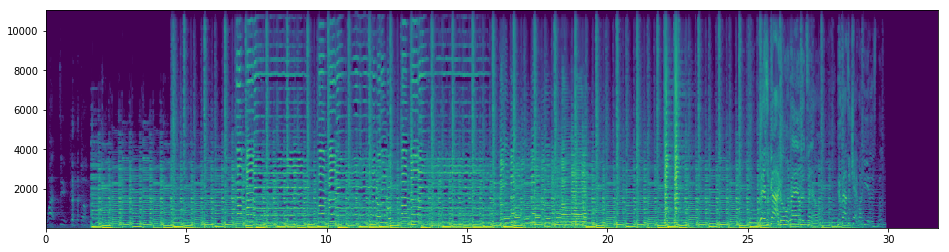

In [9]:
showspec(spec)

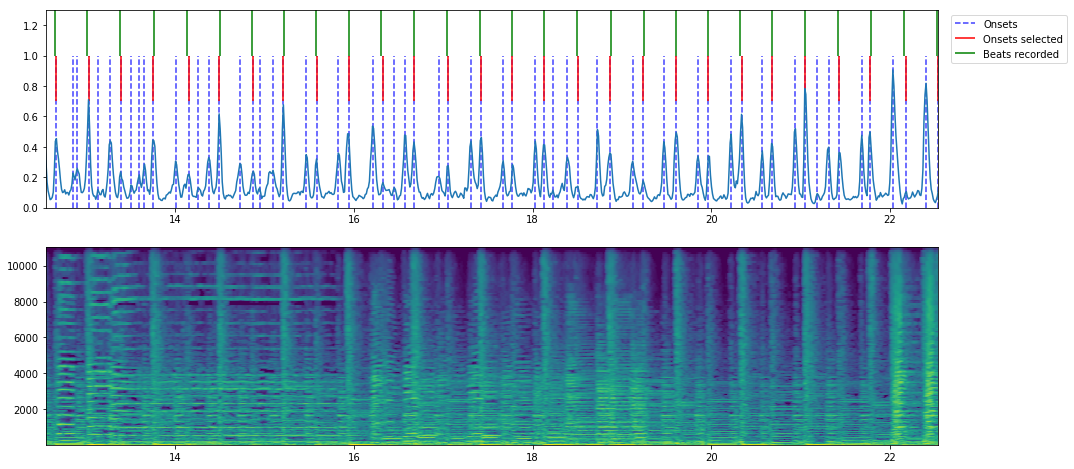

In [10]:
showdata(spec, onsets, isbeat, beats, duration=10)

# Find learning rate

In [11]:
model = BeatTracker()
model.to(device)

BeatTracker(
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (hid_to_beat): Linear(in_features=256, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

Either GTZAN

In [ ]:
dataset = GTZAN(style='disco', idxs=20, transform=totensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
n_mb = len(dataloader) # number of minibatches
lr = (10. ** -np.arange(0, 10, 10 / n_mb))[::-1]

Or BALLROOM

In [14]:
dataset = BALLROOM.BALLROOM(20, transform=totensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
n_mb = len(dataloader) # number of minibatches
lr = (10. ** -np.arange(0, 10, 10 / n_mb))[::-1]

Then find lr

In [15]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    print(f'{i + 1}/{n_mb}')
    model.set_lr(lr[i])
    loss, accuracy = model.learn(specs, onsets, isbeat)
    losses[i] = loss

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


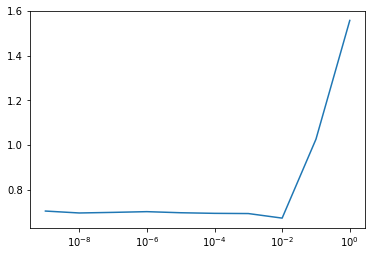

In [19]:
plt.semilogx(lr, losses);

# Training of the model

In [20]:
model = BeatTracker()
model.to(device)
print_params(model)
model.freeze()
model.eval()

 ----------------------------------------------------------
| lstm.weight_ih_l0            | [512, 256]   |    131,072 |
| lstm.weight_hh_l0            | [512, 128]   |     65,536 |
| lstm.bias_ih_l0              | [512]        |        512 |
| lstm.bias_hh_l0              | [512]        |        512 |
| lstm.weight_ih_l0_reverse    | [512, 256]   |    131,072 |
| lstm.weight_hh_l0_reverse    | [512, 128]   |     65,536 |
| lstm.bias_ih_l0_reverse      | [512]        |        512 |
| lstm.bias_hh_l0_reverse      | [512]        |        512 |
| lstm.weight_ih_l1            | [512, 256]   |    131,072 |
| lstm.weight_hh_l1            | [512, 128]   |     65,536 |
| lstm.bias_ih_l1              | [512]        |        512 |
| lstm.bias_hh_l1              | [512]        |        512 |
| lstm.weight_ih_l1_reverse    | [512, 256]   |    131,072 |
| lstm.weight_hh_l1_reverse    | [512, 128]   |     65,536 |
| lstm.bias_ih_l1_reverse      | [512]        |        512 |
| lstm.bias_hh_l1_reverse

BeatTracker(
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (hid_to_beat): Linear(in_features=256, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

Either GTZAN

In [ ]:
dataset = GTZAN(style='disco', idxs=20, transform=totensor)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
trainset, validset = random_split(dataset, [train_size, valid_size])

print(f'Train size: {train_size}')
print(f'Valid size: {valid_size}')

Or BALLROOM

In [21]:
dataset = BALLROOM.BALLROOM(20, transform=totensor)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
trainset, validset = random_split(dataset, [train_size, valid_size])

print(f'Train size: {train_size}')
print(f'Valid size: {valid_size}')

Train size: 16
Valid size: 4


Evaluate

In [22]:
confusion(*model.evaluate_from_dataset(validset))

 -------------------
| tp:   0 | fp:   1 |
| fn: 260 | tn: 245 |
 -------------------
Precision: 0.0000
   Recall: 0.0000
 Accuracy: 0.4842


In [23]:
confusion(*model.evaluate_from_dataset(trainset))

 ---------------------
| tp:    2 | fp:    8 |
| fn: 1139 | tn: 1403 |
 ---------------------
Precision: 0.2000
   Recall: 0.0018
 Accuracy: 0.5505


Train

In [24]:
model.unfreeze()
model.train();

In [25]:
lost_hist, accu_hist, valid_hist = model.fit(trainset, validset, batch_size=4, epochs=10)

| Epoch:  1 | Loss:  0.6538 | Valid loss:  0.6523 | Accuracy: 0.6176 | 6.36 s/b | Eta: 0:03:49 |
| Epoch:  2 | Loss:  0.6041 | Valid loss:  0.5972 | Accuracy: 0.6857 | 6.26 s/b | Eta: 0:03:20 |
| Epoch:  3 | Loss:  0.5533 | Valid loss:  0.5358 | Accuracy: 0.7346 | 6.61 s/b | Eta: 0:03:05 |
| Epoch:  4 | Loss:  0.4782 | Valid loss:  0.5092 | Accuracy: 0.8041 | 6.24 s/b | Eta: 0:02:29 |
| Epoch:  5 | Loss:  0.4072 | Valid loss:  0.4049 | Accuracy: 0.8214 | 6.22 s/b | Eta: 0:02:04 |
| Epoch:  6 | Loss:  0.3373 | Valid loss:  0.3948 | Accuracy: 0.8611 | 6.12 s/b | Eta: 0:01:37 |
| Epoch:  7 | Loss:  0.2563 | Valid loss:  0.4300 | Accuracy: 0.8923 | 6.13 s/b | Eta: 0:01:13 |
| Epoch:  8 | Loss:  0.2320 | Valid loss:  0.3386 | Accuracy: 0.9034 | 6.16 s/b | Eta: 0:00:49 |
| Epoch:  9 | Loss:  0.1715 | Valid loss:  0.4217 | Accuracy: 0.9349 | 6.28 s/b | Eta: 0:00:25 |
| Epoch: 10 | Loss:  0.1427 | Valid loss:  0.3676 | Accuracy: 0.9496 | 7.59 s/b | Eta: 0:00:00 |


ValueError: too many values to unpack (expected 2)

In [26]:
plt.plot(np.mean(lost_hist, axis=1))

NameError: name 'lost_hist' is not defined

Reevaluate

In [27]:
confusion(*model.evaluate_from_dataset(validset))

 -------------------
| tp: 214 | fp:  44 |
| fn:  46 | tn: 202 |
 -------------------
Precision: 0.8295
   Recall: 0.8231
 Accuracy: 0.8221


In [28]:
confusion(*model.evaluate_from_dataset(trainset))

 ---------------------
| tp: 1115 | fp:   92 |
| fn:   26 | tn: 1319 |
 ---------------------
Precision: 0.9238
   Recall: 0.9772
 Accuracy: 0.9538


Save

In [ ]:
#torch.save(model.state_dict(), './data/model_02.pt')

# Test

In [29]:
from GTZAN import *
from IPython.display import Audio

def unibatch(spec_np, onsets_np, isbeat_np):
    """ Get a minibatch of one sample from the original numpy data."""
    spec, onsets, isbeat = totensor((spec_np, onsets_np, isbeat_np))
    spec = spec.unsqueeze(0)
    onsets = onsets.unsqueeze(0)
    isbeat = isbeat.unsqueeze(0)
    return spec, onsets, isbeat

Load the pretrained model and freeze its parameters.

In [ ]:
model = BeatTracker(hidden_size=256, num_layers=3)
model.load_state_dict(torch.load('./data/model_03.pt', map_location=device))
model.eval()
model.freeze()

Take a random example from the GTZAN dataset.

In [ ]:
s = np.random.choice(styles)
n = np.random.randint(20)
wav_file = filename_audio(s, n)
spec_np, onsets_np, isbeat_np, beats_np = loadGTZAN(s, n, True)

Or from the BALLROOM dataset.

In [40]:
dataset = BALLROOM.BALLROOM(20)

In [51]:
i = np.random.randint(20)
spec_np, onsets_np, isbeat_np = dataset[i]
beats_np = BALLROOM.load_beats(i)
wav_file = BALLROOM.wav_file(i)

Compute the beat track from the RNN algorithm and compare with librosa and ground truth.

In [47]:
# RNN
spec, onsets, isbeat = unibatch(spec_np, onsets_np, isbeat_np)
pred = model.predict(spec, onsets)
bt = beat_track(pred)
bt_times = librosa.frames_to_time(bt, sr, hl)

In [48]:
# Librosa
onset_envelope = librosa.onset.onset_strength(S=spec_np)
tempo, bt_lib = librosa.beat.beat_track(onset_envelope=onset_envelope)
bt_lib_times = librosa.frames_to_time(bt_lib, sr, hl)

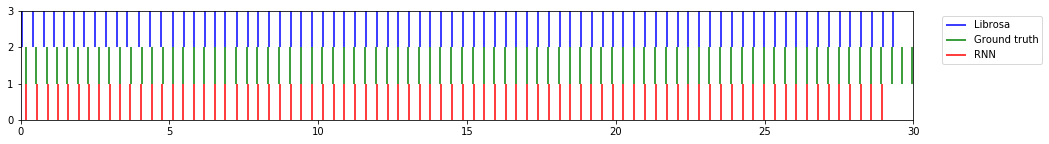

In [49]:
plt.figure(figsize=(16, 2))
plt.vlines(bt_lib_times, 2, 3, color='b', label='Librosa')
plt.vlines(beats_np, 1, 2, color='g', label='Ground truth')
plt.vlines(bt_times, 0, 1, color='r', label='RNN')
plt.xlim(0, 30)
plt.ylim(0, 3)
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1));

Listen to the three different beat tracks.

In [52]:
wav = librosa.load(wav_file, sr=sr)[0]
Audio(wav, rate=sr)

In [53]:
# RNN
click = librosa.clicks(bt_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [54]:
# Librosa
click = librosa.clicks(bt_lib_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [55]:
# Ground truth (sort of)
click = librosa.clicks(beats_np, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)